In [3]:
import torch
from conex.helpers.filters import DoGFilter 
import matplotlib.pyplot as plt 
import numpy as np

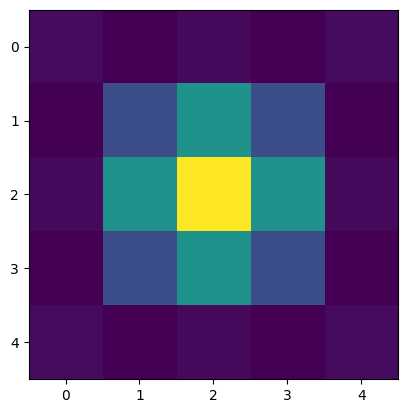

In [4]:
a = DoGFilter(size=5, sigma_1=1, sigma_2=2)
a.size()
plt.imshow(a)
plt.show()

In [16]:
class Color_DoG:
    
    def __init__(self, sigma1, sigma2, kernel_size=3, stride=1, mode="on_center_off_surround", channel_mode="RG"):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.kernel_size = kernel_size
        self.stride = stride
        self.mode = mode
        self.dict_mode = {"on_center_off_surround": 1, "off_center_on_surround": -1}
        self.channel_mode = channel_mode
        self.ch_dict = {"RG":[2, 1], "GR":[1, 2], "BY":[0, 1, 2], "YB":[1, 2, 0]}
        
    def GaussianFunctionFilter(self, sigma):
        scale = (self.kernel_size - 1) / 2

        v_range = torch.arange(-scale, scale + self.stride, self.stride, dtype=torch.float32)
        x, y = torch.meshgrid(v_range, v_range, indexing="ij")

        g_values = -(x**2 + y**2) / 2

        dog = torch.exp(g_values / (sigma**2)) / sigma
        
        dog_filter = (dog) / torch.sqrt(
            torch.tensor(2 * torch.pi, dtype=torch.float32)
        )

        return dog_filter
    
    def DoGFilter(self):
        self.filt = torch.zeros((self.kernel_size, self.kernel_size, 3))
        sigma_lst = torch.tensor([self.sigma1, self.sigma2, self.sigma2], dtype=torch.float32)
        if self.channel_mode == "YB":
            sigma_lst = torch.tensor([self.sigma1, self.sigma1, self.sigma2], dtype=torch.float32)
        sigma_lst = sigma_lst[self.ch_dict[self.channel_mode]]
        for ind, channel in enumerate(self.ch_dict[self.channel_mode]):
            self.filt[:, :, channel] = self.GaussianFunctionFilter(sigma=sigma_lst[ind])
        
        return self.filt
    
    ### TO DO: use torch 
        
    # def convolve_DoG(self, img):
    #     pad = (self.kernel_size - 1) // 2
    #     image = torch.nn.functional.pad(input=img, pad=(0, 0, pad, pad, pad, pad))
    #     final_image = torch.conv3d(input=image, weight=self.filt, stride=self.stride, padding=pad)
    #     return final_image
        
    
    def convolve_DoG(self, img):
        pad = (self.kernel_size-1)//2
        image = torch.nn.functional.pad(input=img, pad=(0, 0, pad, pad, pad, pad))
        
        final_img = torch.zeros((image.shape[0]-self.kernel_size + 1)//self.stride, (image.shape[1]-self.kernel_size + 1)//self.stride, 3)
        
        for c in range(len(self.ch_dict[self.channel_mode])):
            stride_x = 0
            for i in range(final_img.shape[0]):
                stride_y = 0
                for j in range(final_img.shape[1]):
                    apply_filter = torch.sum(image[stride_x:stride_x+self.kernel_size, stride_y:stride_y+self.kernel_size, self.ch_dict[self.channel_mode][c]] *
                                             self.filt[:,:,self.ch_dict[self.channel_mode][c]] * self.dict_mode[self.mode])
                    final_img[i][j][self.ch_dict[self.channel_mode][c]] = apply_filter
                    stride_y += self.stride
                stride_x += self.stride

        return final_img


tensor([[[[-1.7526e-01,  6.1431e-01, -2.8381e-01,  ...,  2.3672e-02,
            1.3669e+00, -2.3987e-01],
          [ 9.7324e-01,  8.9348e-01,  3.7885e-02,  ..., -1.0473e-01,
           -7.0483e-01,  1.2579e-01],
          [ 2.6070e-01,  5.7773e-01, -2.7039e-01,  ...,  7.0093e-02,
            1.7974e-01, -7.2967e-01],
          ...,
          [ 3.9483e-01, -9.0147e-03,  8.6321e-01,  ...,  1.0497e+00,
            1.1735e+00,  3.6413e-01],
          [ 7.5459e-01,  3.1047e-01, -1.9915e-01,  ..., -1.6902e-01,
            1.8632e-01, -7.9224e-01],
          [-6.1327e-01,  3.0673e-01, -4.0021e-01,  ...,  6.6107e-01,
            3.3124e-01,  2.8192e-01]],

         [[ 3.1794e-01, -2.5449e-01,  1.8851e+00,  ..., -5.6777e-01,
            2.7866e-01,  1.8300e+00],
          [ 2.4121e-01, -5.1755e-01, -9.5726e-02,  ..., -9.6890e-01,
           -3.4299e-01,  3.1277e-01],
          [-1.1933e+00,  1.7984e-01, -2.3690e-01,  ..., -6.8153e-01,
           -4.9961e-01, -8.3663e-01],
          ...,
     

In [10]:
import os 

img = plt.imread(fname="cat.jpg")
img = torch.tensor(img)
img = img[:186, :186]
filter = Color_DoG(sigma1=1, sigma2=2, kernel_size=15)
filt = filter.DoGFilter()
final_img = filter.convolve_DoG(img=img)



RuntimeError: Expected 4D (unbatched) or 5D (batched) input to conv3d, but got input of size: [200, 200, 3]

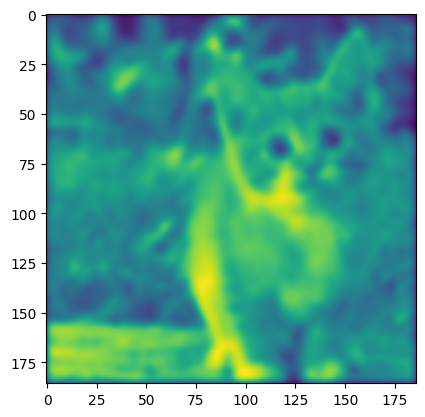

In [ ]:
plt.imshow(final_img[:, :, 1])

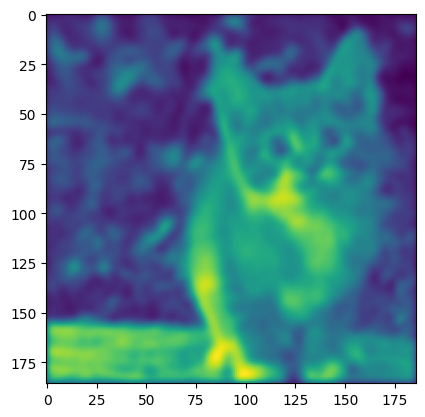

In [ ]:
plt.imshow(final_img[:, :, 2])